

---

#Modelos Supervisionados para óbitos do COVID-19

---



In [ ]:
!pip install -U scikit-fuzzy

     |████████████████████████████████| 993 kB 7.6 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=ae9fcf67da23a4c8665a5617e6ce76b234f475ec5d5c750b9c9201bfea2cf9a5
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


In [ ]:
!pip install fuzzy-c-means

     |████████████████████████████████| 15.7 MB 56 kB/s 
     |████████████████████████████████| 10.1 MB 29.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
#Importação dos pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter, OrderedDict
import statsmodels.api as sm
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import DistanceMetric
from sklearn.svm import SVR, SVC
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
from fcmeans import FCM
from sklearn.model_selection import train_test_split

In [ ]:
# Abertura do Drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Caminho do csv no Drive
# path = '/content/drive/MyDrive/INFLUD21-13-09-2021.csv'
path = '/content/drive/MyDrive/Dataset/Cópia de INFLUD21-13-09-2021.csv'

In [ ]:
# Leitura do csv
df = pd.read_csv(path, sep=';')
# Exibição dos dados
df.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,18,60,62,63,64,92,94,106,108,115,117,118,119,123,144) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,...,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,FNT_IN_COV
0,05/01/2021,1,03/01/2021,1,PR,09RS FOZ DO IGUACU,1363.0,MATELANDIA,411560,HOSPITAL E MATERNIDADE PADRE TEZZA,2588188,M,06/07/1932,88,3,3088,6,1,NaN,NaN,BRASIL,1,PR,09RS FOZ DO IGUACU,1363.0,MATELANDIA,411560.0,1.0,NaN,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0
1,07/01/2021,1,04/01/2021,1,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSP STA CRUZ,2082624,M,29/06/1950,70,3,3070,6,4,NaN,9.0,BRASIL,1,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,NaN,NaN,2.0,1.0,2.0,2.0,2.0,NaN,07/01/2021,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,09/01/2021,1,07/01/2021,1,SP,GVE VIII MOGI DAS CRUZES,1333.0,ITAQUAQUECETUBA,352310,HOSPITAL GERAL DE ITAQUAQUECETUBA,2078562,F,24/01/1925,95,3,3095,5,4,NaN,NaN,BRASIL,1,SP,GVE VIII MOGI DAS CRUZES,1333.0,ITAQUAQUECETUBA,352310.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,...,NaN,NaN,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08/01/2021,1,05/01/2021,1,SP,GVE XVII CAMPINAS,1342.0,CAMPINAS,350950,HOSPITAL DAS CLINICAS DA UNICAMP DE CAMPINAS,2079798,F,21/10/1960,60,3,3060,5,1,NaN,9.0,BRASIL,1,SP,GVE XX PIRACICABA,1345.0,ELIAS FAUSTO,351490.0,1.0,2.0,2.0,9.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,9.0,...,NaN,NaN,2.0,1.0,2.0,2.0,6.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11/01/2021,2,07/01/2021,1,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSP STA MAGGIORE BELA VISTA,2084341,F,27/06/1936,84,3,3084,6,4,NaN,NaN,BRASIL,1,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,RAD COVID1,10/01/2021,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Verificando a existência das colunas
my_columns = list(df.columns)
for i in range(len(my_columns)):
  if (my_columns[i][0:4] == "INTE"):
    print(my_columns[i])

In [ ]:
# Remoção de colunas não necessárias para o objetivo
df = df.drop(columns=["DT_NOTIFIC", "DT_SIN_PRI", "SG_UF_NOT", "ID_REGIONA", "CO_REGIONA", "ID_MUNICIP", 
 "CO_MUN_NOT", "ID_UNIDADE", "CO_UNI_NOT", "DT_NASC", "TP_IDADE", "COD_IDADE", "CS_RACA", "CS_ETINIA",
 "CS_ESCOL_N", "ID_PAIS", "CO_PAIS", "ID_RG_RESI", "CO_RG_RESI", "ID_MN_RESI", "CO_MUN_RES", "CS_ZONA", 
 "DT_DIGITA", "DT_ENCERRA", "DT_RES", "DT_CO_SOR",
  "DS_PCR_OUT", "DT_PCR", "DS_AN_OUT", "RES_AN", "DT_RES_AN",
"OUT_AMOST", "TP_AMOSTRA", "DT_COLETA", "DT_TOMO", "ID_MUNICIP", "ID_REGIONA",
"ID_UNIDADE", "DT_NASC", "NU_IDADE_N", "TP_IDADE" ,
 "PAC_COCBO", "PAC_DSCBO", "ID_RG_RESI", "ID_MN_RESI",
 "AVE_SUINO", "DOSE_1_COV", "DOSE_2_COV", "LOTE_1_COV", "LOTE_2_COV", "FNT_IN_COV", "DT_UT_DOSE", "ANTIVIRAL", "OUT_ANTIV", "DT_ANTIVIR", "DT_INTERNA",
"ID_RG_INTE", "ID_MN_INTE", "DT_ENTUTI", "DT_SAIDUTI", "SUPORT_VEN",
"RAIOX_OUT", "DT_RAIOX", "SURTO_SG","MORB_DESC", "DT_VAC_MAE", "MAE_VAC", "FLUBLI_OUT", "CLASSI_OUT", "DT_EVOLUCA", "DT_DOSEUNI", "DT_1_DOSE", "DT_2_DOSE"])
df

,SEM_NOT,SEM_PRI,CS_SEXO,CS_GESTANT,SG_UF,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,OUT_MORBI,VACINA,M_AMAMENTA,TP_ANTIVIR,HOSPITAL,SG_UF_INTE,CO_RG_INTE,CO_MU_INTE,UTI,RAIOX_RES,...,PCR_RINO,PCR_OUTRO,CLASSI_FIN,CRITERIO,EVOLUCAO,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,TP_TES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,TP_AM_SOR,SOR_OUT,TP_SOR,OUT_SOR,RES_IGG,RES_IGM,RES_IGA,ESTRANG,VACINA_COV,LAB_PR_COV
0,1,1,M,6,PR,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,1.0,PR,1363.0,411560.0,2.0,NaN,...,NaN,NaN,4.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1,1,1,M,6,SP,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,1.0,9.0,NaN,NaN,1.0,SP,1331.0,355030.0,2.0,6.0,...,NaN,NaN,4.0,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,F,5,SP,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,NaN,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,2.0,SP,NaN,NaN,NaN,6.0,...,NaN,NaN,4.0,1.0,2.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,F,5,SP,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,9.0,NaN,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,NaN,9.0,9.0,NaN,NaN,1.0,SP,1342.0,350950.0,1.0,2.0,...,NaN,NaN,4.0,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1,F,6,SP,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,CEFALEIA,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,SP,1331.0,355030.0,2.0,NaN,...,NaN,NaN,4.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,RAD COVID1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471565,35,35,F,6,SC,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,SC,1558.0,420460.0,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN
1471566,36,35,M,6,PR,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,NaN,NaN,1.0,PR,1355.0,411820.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,BRONCOASPIRACAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,CORONAVAC
1471567,36,36,M,6,SP,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN,NaN,1,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,SP,1342.0,352590.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN
1471568,36,36,F,5,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,SP,1342.0,352590.0,2.0,9.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,PFIZE

In [ ]:
# Verificando se uma coluna tem mais de 80% de dados nulos, se sim haverá a sua exclusão
for i in df.columns:
  n = df[i].isnull().sum()
  if n >= (1471570 * 0.8):
    df = df.drop(columns=[i])

In [ ]:
# Remoção de nulo
df = df.dropna(axis=0)

In [ ]:
# Exibição do novo dataframe
df

,SEM_NOT,SEM_PRI,CS_SEXO,CS_GESTANT,SG_UF,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,VACINA,HOSPITAL,SG_UF_INTE,CO_RG_INTE,CO_MU_INTE,UTI,RAIOX_RES,AMOSTRA,PCR_RESUL,POS_PCRFLU,POS_PCROUT,CLASSI_FIN,CRITERIO,EVOLUCAO,HISTO_VGM,PCR_SARS2,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,ESTRANG,VACINA_COV
117,3,2,F,6,SP,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,"CEFALEIA,CORIZA",2.0,1,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,SP,1354.0,354980.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0
263,4,2,F,5,SP,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,FRAQUEZA,2.0,1,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,SP,1335.0,353440.0,1.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
286,2,2,F,9,AL,9.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,ASTENIA/ MIALGIA,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,1.0,9.0,1.0,AL,1533.0,270430.0,2.0,9.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
372,4,3,M,6,BA,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,MIALGIA CORIZA CEFALEIA ADINAM,2.0,1,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,9.0,1.0,BA,1380.0,292740.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0
406,4,2,M,6,BA,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,CEFALEIA,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,9.0,1.0,BA,1380.0,292740.0,1.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471026,33,32,F,5,GO,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,ASTENIA,2.0,1,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,GO,1792.0,520110.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
1471219,31,28,F,9,GO,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,MIALGIA,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,GO,1781.0,520140.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,9.0
1471320,30,28,M,6,SP,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,FR32,2.0,1,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,9.0,1.0,SP,1342.0,350950.0,1.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,6.0,2.0,9.0
1471438,25,25,F,6,GO,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,"MIALGIA, DOR NAS COSTAS",2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,GO,1792.0,520110.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,6.0,2.0,2.0


In [ ]:
#Removendo linhas com sexo indefinido
df = df[df["CS_SEXO"] != "I"] 

In [ ]:
 #Recebendo todas as colunas float
float_columns = []
for i in df.columns:
  if (df[i].dtypes == "float64"):
    float_columns.append(i)

In [ ]:
#Filtrando as colunas para remoção do valor 9.0
for i in float_columns:
  df = df[df[i] != 9.0] 

In [ ]:
#Verificando a quantidade de pessoas que tomaram vacina
df.groupby('VACINA') ['VACINA'].count()

VACINA
1.0    1395
2.0    5846
Name: VACINA, dtype: int64

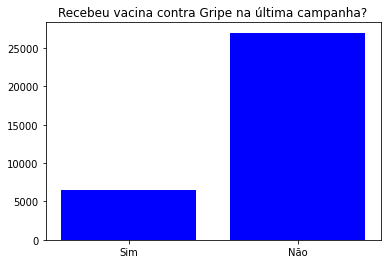

In [ ]:
#Gráfico sobre indivíduos que tomaram vacina da gripe
ca = ['Sim','Não']
ca_num = [6464, 27012]
plt.bar(ca,ca_num,color = 'blue')
plt.title('Recebeu vacina contra Gripe na última campanha?')
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando a quantidade de pessoas que tomaram vacina contra COVID-19
df.groupby('VACINA_COV') ['VACINA_COV'].count()

VACINA_COV
1.0    2124
2.0    5117
Name: VACINA_COV, dtype: int64

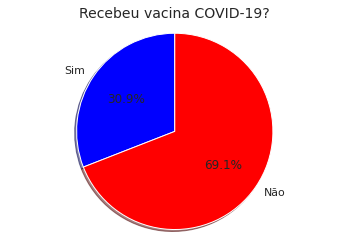

In [ ]:
#Gráfico sobre indivíduos que tomaram vacina da COVID - 19
labels = ['Sim','Não']
size = [10353, 23123]
color_list = ['blue','red']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 90,colors=color_list)
axl.axis('equal')
axl.set_title('Recebeu vacina COVID-19?',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
# Verificando a quantidade de gestantes
df.groupby('CS_GESTANT') ['CS_GESTANT'].count()

CS_GESTANT
1       7
2      13
3      63
4       3
5    2959
6    4128
9      68
Name: CS_GESTANT, dtype: int64

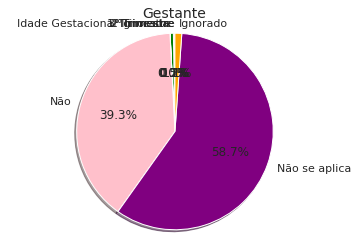

In [ ]:
# Exibindo a quantidade de gestantes
labels = ['1° Trimestre','2°Trimestre','3°Trimestre', 'Idade Gestacional Ignorada', 'Não', 'Não se aplica','Ignorado']
size = [20, 65, 181, 6, 13172, 19659,373]
color_list = ['blue','red','green','yellow','pink','Purple','Orange']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 90,colors=color_list)
axl.axis('equal')
axl.set_title('Gestante',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
# plt.figure(figsize=(150,50))
plt.show()

In [ ]:
# Verificando a evolução do caso
df.groupby('EVOLUCAO') ['EVOLUCAO'].count()

EVOLUCAO
1.0    4426
2.0    2808
3.0       7
Name: EVOLUCAO, dtype: int64

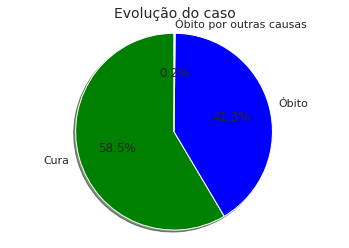

In [ ]:
#Gráfico do evolução do caso
labels = ['Cura','Óbito','Óbito por outras causas']
size = [19591, 13826, 59]
color_list = ['green','blue','red']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 90,colors=color_list)
axl.axis('equal')
axl.set_title('Evolução do caso',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
# Verificando a quantidade de pacientes que foram para a UTI
df.groupby('UTI') ['UTI'].count()

UTI
1.0    2893
2.0    4348
Name: UTI, dtype: int64

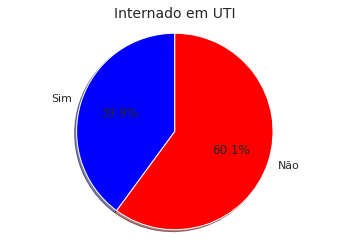

<Figure size 1440x1440 with 0 Axes>

In [ ]:
#Gráfico de indivíduos que estavam na UTI
labels = ['Sim','Não']
size = [13363,20113]
color_list = ['blue','red']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 90,colors=color_list)
axl.axis('equal')
axl.set_title('Internado em UTI',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
# Verificando gestantes
df['CS_GESTANT']

117        6
263        5
1017       6
1780       5
2210       5
          ..
1470106    5
1470510    5
1470900    6
1471026    5
1471438    6
Name: CS_GESTANT, Length: 7241, dtype: int64

In [ ]:
#Valores de gestante:
# 1-1o Trimestre
# 2-2o Trimestre
# 3-3o Trimestre
# 4-Idade Gestacional
# Ignorada
# 5-Não
# 6-Não se aplica
# 9-Ignorado

gravidez_dict = {
    2: 1,
    3: 1,
    4: 1,
    5: 0,
    6: 0,

}

#Discretizando gestante
#De um a quatro, 1, outros valores, 0
df['CS_GESTANT'] = df['CS_GESTANT'].replace(gravidez_dict)
Counter(df['CS_GESTANT'])

Counter({0: 7087, 1: 86, 9: 68})

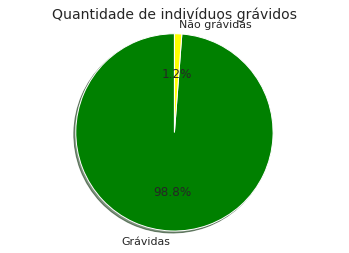

In [ ]:
# Gráfico de percentual de grávidas
labels='Grávidas','Não grávidas'
size =[7087,86]
color_list = ['green','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 90,colors=color_list)
axl.axis('equal')
axl.set_title('Quantidade de indivíduos grávidos',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
# Verificando a análise estatísca
df.describe()

,SEM_NOT,SEM_PRI,CS_GESTANT,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,VACINA,HOSPITAL,CO_RG_INTE,CO_MU_INTE,UTI,RAIOX_RES,AMOSTRA,PCR_RESUL,POS_PCRFLU,POS_PCROUT,CLASSI_FIN,CRITERIO,EVOLUCAO,HISTO_VGM,PCR_SARS2,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,ESTRANG,VACINA_COV
count,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.0,7241.000000,7241.0,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.0,7241.000000,7241.000000,7241.000000,7241.000000,7241.0,7241.0,7241.000000,7241.0,7241.0,7241.000000,7241.000000,7241.0,7241.0,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.000000,7241.00000
mean,18.751001,17.243198,0.096396,1.987433,1.448281,1.292363,1.819362,1.244441,1.417208,1.255490,1.828753,1.890761,1.0,1.994752,1.0,1.502279,1.993233,1.995995,1.990333,1.959812,1.669383,1.957741,1.959398,1.969065,1.952355,1.787460,1.467201,1.807347,1.0,1492.587350,374186.037011,1.600470,5.212954,1.0,1.0,1.999586,1.0,5.0,1.011739,1.389725,0.0,1.0,1.928325,1.658611,1.880265,1.875293,3.113796,1.994062,1.70667
std,6.775219,6.887842,0.873704,0.111405,0.497352,0.454880,0.384745,0.429785,0.493132,0.436166,0.376751,0.311960,0.0,0.072257,0.0,0.500029,0.081989,0.063162,0.097852,0.196413,0.470468,0.201194,0.197380,0.173153,0.213029,0.409133,0.498957,0.394410,0.0,327.003341,77900.345815,0.489836,1.450930,0.0,0.0,0.020352,0.0,0.0,0.166207,0.489700,0.0,0.0,0.257967,0.474209,0.324674,0.330409,2.363635,0.076837,0.45532
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1331.000000,110012.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,5.0,1.000000,1.000000,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
25%,14.000000,12.000000,0.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.0,2.000000,1.0,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.0,1354.000000,317020.000000,1.000000,5.000000,1.0,1.0,2.000000,1.0,5.0,1.000000,1.000000,0.0,1.0,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.00000
50%,18.000000,17.000000,0.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.0,1377.000000,354980.000000,2.000000,6.000000,1.0,1.0,2.000000,1.0,5.0,1.000000,1.000000,0.0,1.0,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.00000
75%,24.000000,22.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,1564.000000,420240.000000,2.000000,6.000000,1.0,1.0,2.000000,1.0,5.0,1.000000,2.000000,0.0,1.0,2.000000,2.000000,2.000000,2.000000,6.000000,2.000000,2.00000
max,36.000000,35.000000,9.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,6255.000000,522200.000000,2.000000,6.000000,1.0,1.0,2.000000,1.0,5.0,4.000000,3.000000,0.0,1.0,2.000000,2.000000,2.000000,2.000000,6.000000,2.000000,2.00000


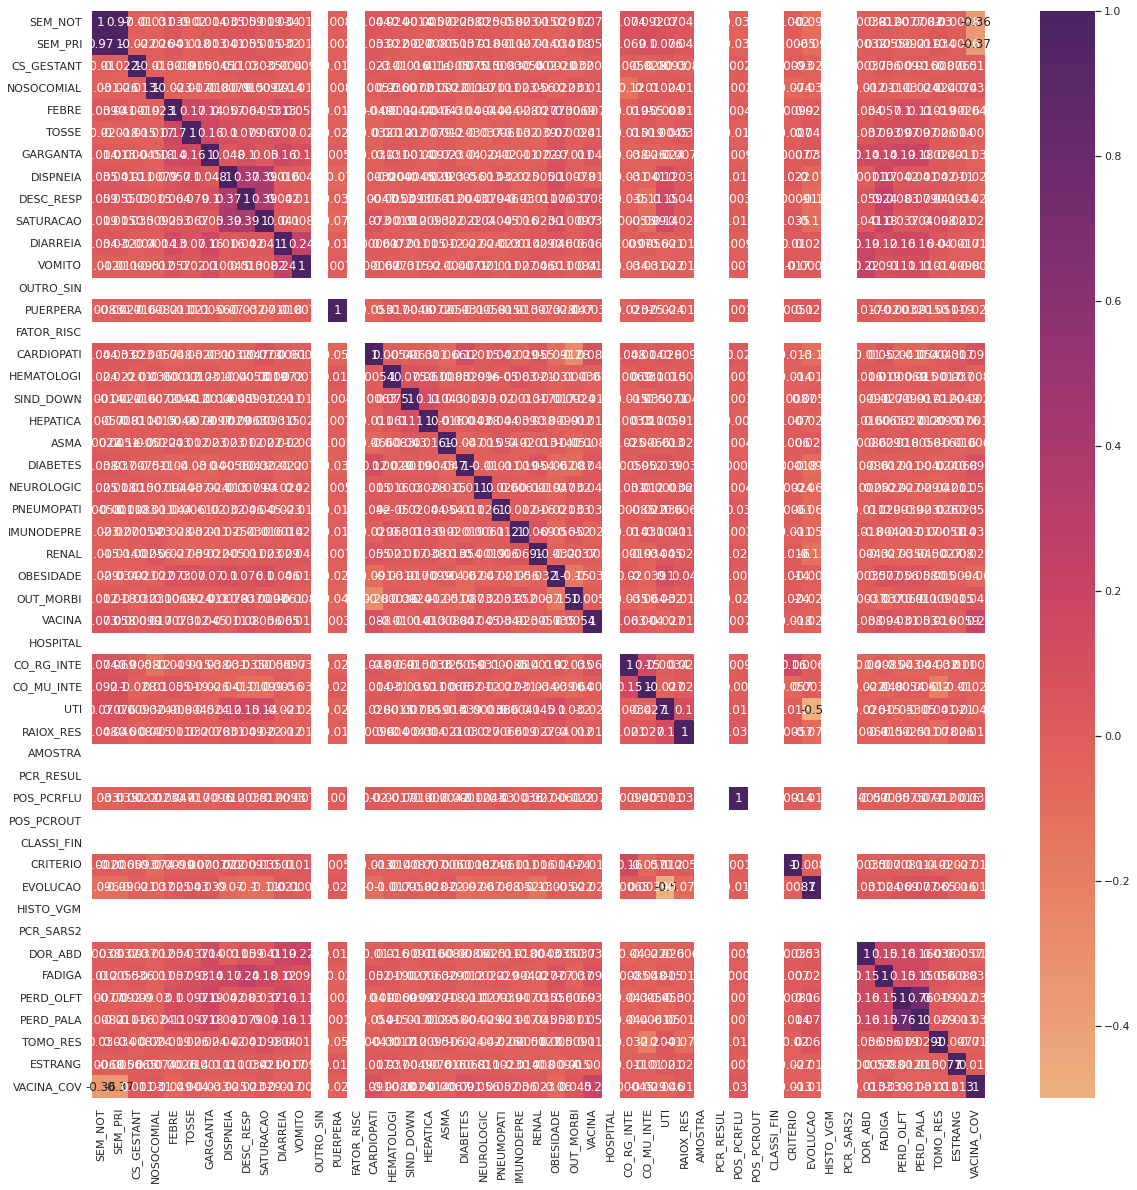

In [ ]:
# Gráfico de correlação 
plt.figure(figsize=(20,20))
heat = sns.heatmap(df.corr(), cmap='flare', annot=True)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4c201cad0>,
      dtype=object)

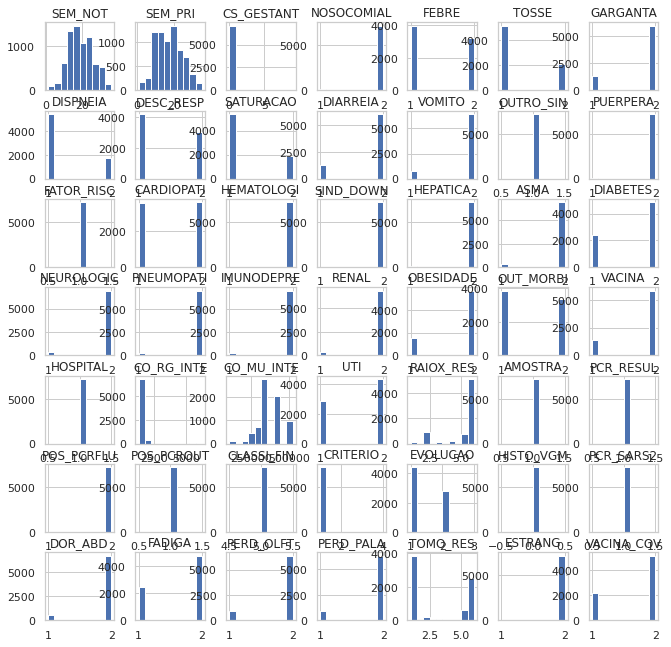

In [ ]:
# Histograma dos dados
df[df.dtypes[(df.dtypes=="float64")| (df.dtypes=="int64")].index.values].hist(figsize=[11,11])

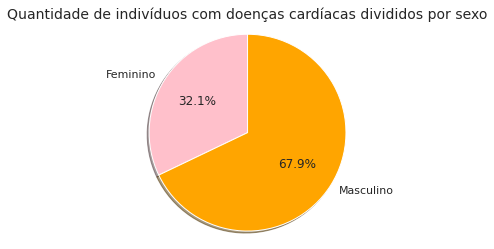

In [ ]:
labels='Feminino','Masculino'
size =[32.1,67.9]
color_list = ['pink','orange']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 90,colors=color_list)
axl.axis('equal')
axl.set_title('Quantidade de indivíduos com doenças cardíacas divididos por sexo',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
woorld = np.array(df['SG_UF'])
dict = OrderedDict(Counter(woorld).most_common(10)) #Separação dos 10 estados mais comuns
dict

OrderedDict([('SP', 2240),
             ('MG', 1202),
             ('PR', 1200),
             ('GO', 481),
             ('RS', 443),
             ('MS', 411),
             ('SC', 403),
             ('PB', 323),
             ('MT', 98),
             ('CE', 89)])

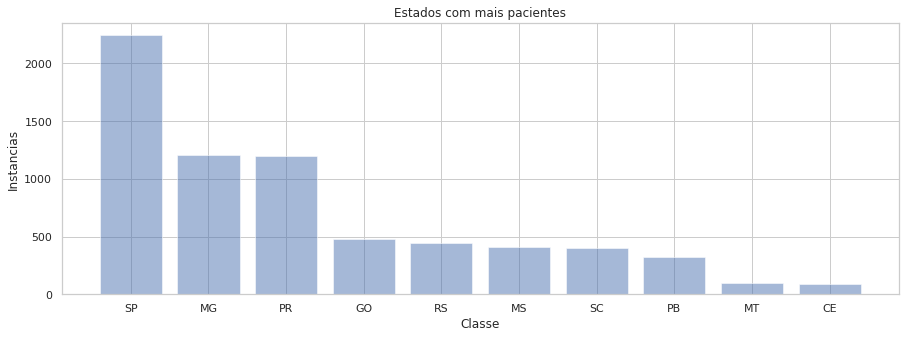

In [ ]:
plt.figure(figsize=(15,5))
plt.ylabel('Instancias')
plt.xlabel('Classe')
plt.title('Estados com mais pacientes')
bars = Counter(dict).keys()
x_pos = np.arange(len(bars))
plt.bar(x_pos, dict.values(), align='center', alpha=0.5)
plt.xticks(x_pos, bars)
plt.show()
plt.close()

In [ ]:
# Verificando a cura de individuos de por UF
uf_life = np.array(df['SG_UF'].loc[df['EVOLUCAO'] == 1.0])
dict_life = OrderedDict(Counter(uf_life).most_common(20))

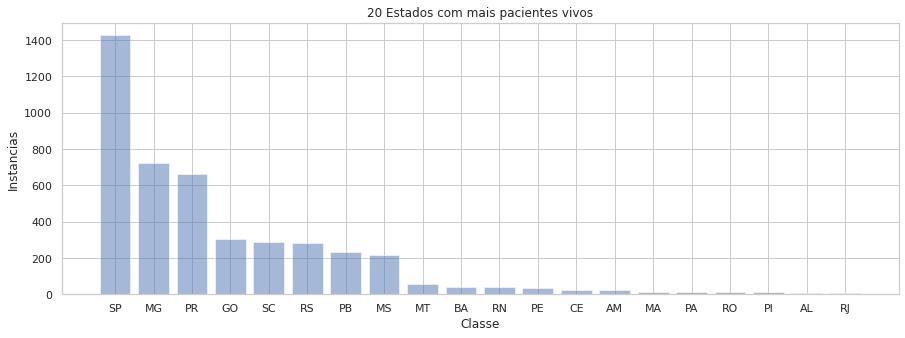

In [ ]:
plt.figure(figsize=(15,5))
plt.ylabel('Instancias')
plt.xlabel('Classe')
plt.title('20 Estados com mais pacientes vivos')
bars = Counter(dict_life).keys()
x_pos = np.arange(len(bars))
plt.bar(x_pos, dict_life.values(), align='center', alpha=0.5)
plt.xticks(x_pos, bars)
plt.show()
plt.close()

In [ ]:
# Verificando a óbitos de individuos de por UF
uf_died = np.array(df['SG_UF'].loc[df['EVOLUCAO'] == 2.0])
dict_died  = OrderedDict(Counter(uf_died).most_common(20))

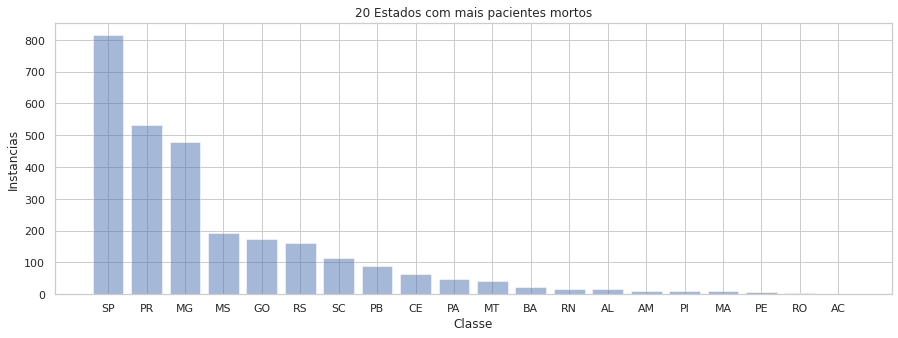

In [ ]:
plt.figure(figsize=(15,5))
plt.ylabel('Instancias')
plt.xlabel('Classe')
plt.title('20 Estados com mais pacientes mortos')
bars = Counter(dict_died).keys()
x_pos = np.arange(len(bars))
plt.bar(x_pos, dict_died.values(), align='center', alpha=0.5)
plt.xticks(x_pos, bars)
plt.show()
plt.close()

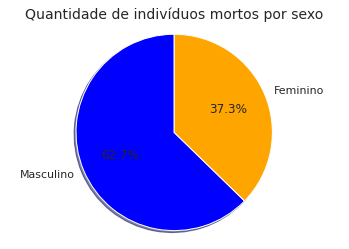

In [ ]:
labels='Masculino', 'Feminino'
size =[37,22]
color_list = ['blue','orange']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 90,colors=color_list)
axl.axis('equal')
axl.set_title('Quantidade de indivíduos mortos por sexo',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Evolução de cura dos casos por sexo
live_sex = np.array(df['CS_SEXO'].loc[df['EVOLUCAO'] == 2.0])
dictlive_sex  = OrderedDict(Counter(live_sex))
dictlive_sex

OrderedDict([('F', 1272), ('M', 1536)])

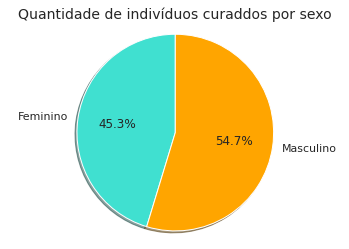

In [ ]:
labels='Feminino', 'Masculino' 
size =[1272,1536]
color_list = ['turquoise','orange']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 90,colors=color_list)
axl.axis('equal')
axl.set_title('Quantidade de indivíduos curaddos por sexo',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
# Verificando os pacientes que tiveram febre
f_t = Counter(df['CS_SEXO'].loc[df['FEBRE'] == 1.0])
f_f = Counter(df['CS_SEXO'].loc[df['FEBRE'] == 2.0])
print('Com febre:', f_t)
print('Sem febre:', f_f)

Com febre: Counter({'M': 2166, 'F': 1829})
Sem febre: Counter({'F': 1707, 'M': 1539})


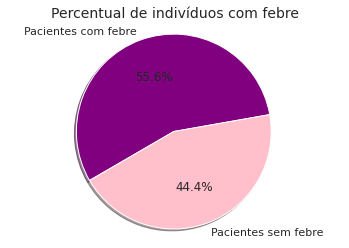

In [ ]:
labels='Pacientes com febre','Pacientes sem febre'
size =[18612,14864]
color_list = ['purple','pink']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos com febre',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

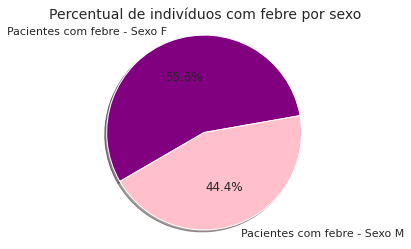

In [ ]:
labels='Pacientes com febre - Sexo F','Pacientes com febre - Sexo M'
size =[18612,14864]
color_list = ['purple','pink']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos com febre por sexo',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
# Verificando os pacientes que tiveram tosse
t_t = Counter(df['CS_SEXO'].loc[df['TOSSE'] == 1.0])
t_f = Counter(df['CS_SEXO'].loc[df['TOSSE'] == 2.0])
print('Pacientes com tosse:', t_t)
print('Pacientes sem tosse:', t_f)

Pacientes com tosse: Counter({'M': 2673, 'F': 2451})
Pacientes sem tosse: Counter({'F': 1085, 'M': 1032})


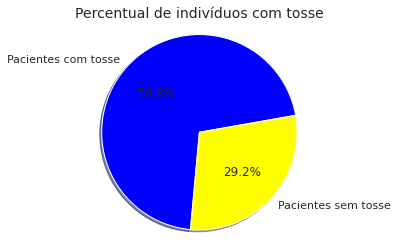

In [ ]:
labels='Pacientes com tosse','Pacientes sem tosse'
size =[t_t['F']+t_t['M'],t_f['M']+t_f['F']]
color_list = ['blue','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos com tosse',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

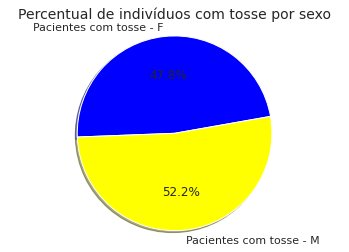

In [ ]:
labels='Pacientes com tosse - F','Pacientes com tosse - M'
size =[t_t['F'], t_t['M']]
color_list = ['blue','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos com tosse por sexo',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que tiveram vômito
v_t = Counter(df['CS_SEXO'].loc[df['VOMITO'] == 1.0])
v_f = Counter(df['CS_SEXO'].loc[df['VOMITO'] == 2.0])
print('Pacientes que apresentaram vômito:', v_t)
print('Pacientes que não apresentaram vômito:', v_f)

Pacientes que apresentaram vômito: Counter({'F': 444, 'M': 347})
Pacientes que não apresentaram vômito: Counter({'M': 3358, 'F': 3092})


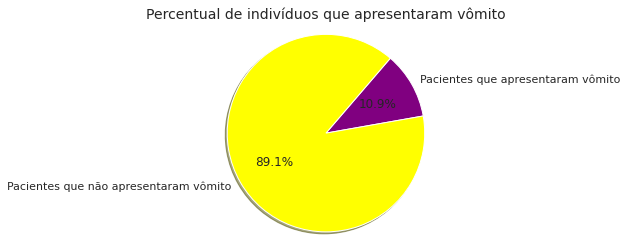

In [ ]:
labels='Pacientes que apresentaram vômito','Pacientes que não apresentaram vômito'
size =[v_t['F']+v_t['M'],v_f['M']+v_f['F']]
color_list = ['purple','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que apresentaram vômito',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

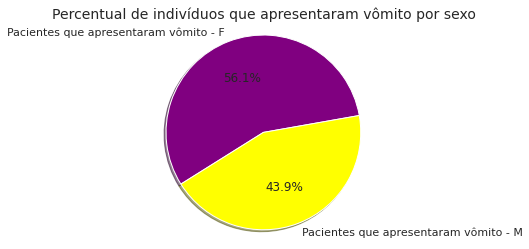

In [ ]:
labels='Pacientes que apresentaram vômito - F','Pacientes que apresentaram vômito - M'
size =[v_t['F'], v_t['M']]
color_list = ['purple','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que apresentaram vômito por sexo',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que tiveram diarréia
d_t = Counter(df['CS_SEXO'].loc[df['DIARREIA'] == 1.0])
d_f = Counter(df['CS_SEXO'].loc[df['DIARREIA'] == 2.0])
print('Pacientes que apresentaram diarréia:', d_t)
print('Pacientes que não apresentaram diarréia:', d_f)

Pacientes que apresentaram diarréia: Counter({'F': 673, 'M': 567})
Pacientes que não apresentaram diarréia: Counter({'M': 3138, 'F': 2863})


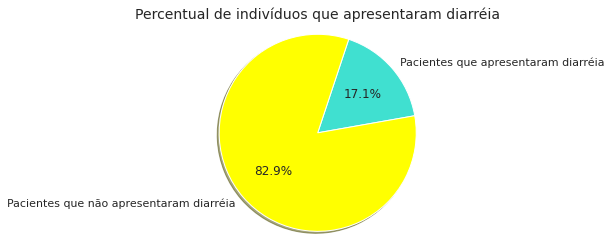

In [ ]:
labels='Pacientes que apresentaram diarréia','Pacientes que não apresentaram diarréia'
size =[d_t['F']+d_t['M'],d_f['M']+d_f['F']]
color_list = ['turquoise','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que apresentaram diarréia',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

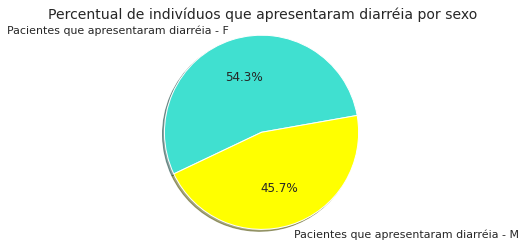

In [ ]:
labels='Pacientes que apresentaram diarréia - F','Pacientes que apresentaram diarréia - M'
size =[d_t['F'], d_t['M']]
color_list = ['turquoise','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que apresentaram diarréia por sexo',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que tiveram asma
a_t = Counter(df['CS_SEXO'].loc[df['ASMA'] == 1.0])
a_f = Counter(df['CS_SEXO'].loc[df['ASMA'] == 2.0])
print('Pacientes que têm asma:', a_t)
print('Pacientes que não têm asma:', a_f)

Pacientes que têm asma: Counter({'F': 164, 'M': 127})
Pacientes que não têm asma: Counter({'M': 3578, 'F': 3372})


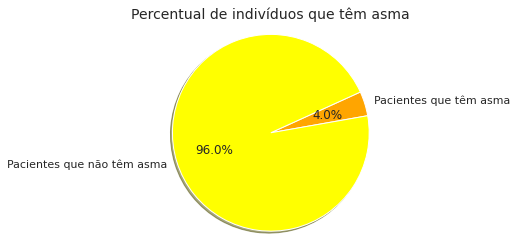

In [ ]:
labels='Pacientes que têm asma','Pacientes que não têm asma'
size =[a_t['F']+a_t['M'],a_f['M']+a_f['F']]
color_list = ['orange','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que têm asma',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que tem diabetes
di_t = Counter(df['CS_SEXO'].loc[df['DIABETES'] == 1.0])
di_f = Counter(df['CS_SEXO'].loc[df['DIABETES'] == 2.0])
print('Pacientes que têm diabetes:', di_t)
print('Pacientes que não têm diabetes:', di_f)

Pacientes que têm diabetes: Counter({'F': 1204, 'M': 1190})
Pacientes que não têm diabetes: Counter({'M': 2515, 'F': 2332})


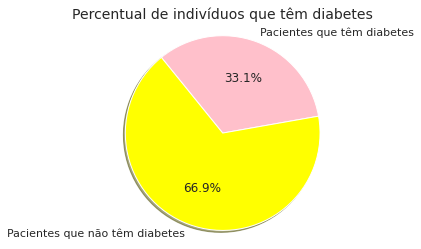

In [ ]:
labels='Pacientes que têm diabetes','Pacientes que não têm diabetes'
size =[di_t['F']+di_t['M'],di_f['M']+di_f['F']]
color_list = ['pink','yellow']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que têm diabetes',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que tem obesidade
ob_t = Counter(df['CS_SEXO'].loc[df['OBESIDADE'] == 1.0])
ob_f = Counter(df['CS_SEXO'].loc[df['OBESIDADE'] == 2.0])
print('Pacientes que têm obesidade:', ob_t)
print('Pacientes que não têm obesidade:', ob_f)

Pacientes que têm obesidade: Counter({'F': 772, 'M': 767})
Pacientes que não têm obesidade: Counter({'M': 2938, 'F': 2764})


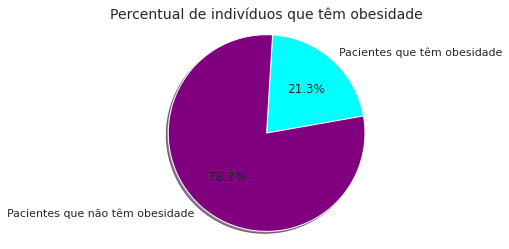

In [ ]:
labels='Pacientes que têm obesidade','Pacientes que não têm obesidade'
size =[ob_t['F']+ob_t['M'],ob_f['M']+ob_f['F']]
color_list = ['cyan','purple']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que têm obesidade',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que têm doenças renais crônicas
re_t = Counter(df['CS_SEXO'].loc[df['RENAL'] == 1.0])
re_f = Counter(df['CS_SEXO'].loc[df['RENAL'] == 2.0])
print('Pacientes que têm doenças renais crônicas:', re_t)
print('Pacientes que não têm doenças renais crônicas:', re_f)

Pacientes que têm doenças renais crônicas: Counter({'M': 203, 'F': 142})
Pacientes que não têm doenças renais crônicas: Counter({'M': 3502, 'F': 3394})


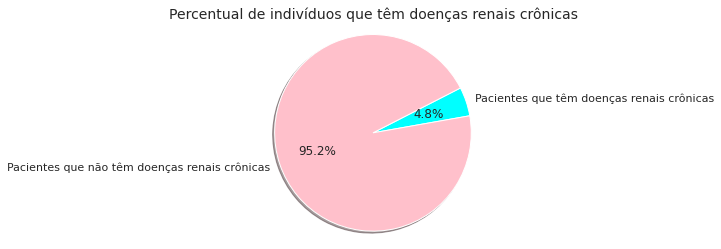

In [ ]:
labels='Pacientes que têm doenças renais crônicas','Pacientes que não têm doenças renais crônicas'
size =[re_t['F']+re_t['M'],re_f['M']+re_f['F']]
color_list = ['cyan','pink']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que têm doenças renais crônicas',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que têm dor de garganta
g_t = Counter(df['CS_SEXO'].loc[df['GARGANTA'] == 1.0])
g_f = Counter(df['CS_SEXO'].loc[df['GARGANTA'] == 2.0])
print('Pacientes que têm dor de garganta:', g_t)
print('Pacientes que não têm dor de garganta:', g_f)

Pacientes que têm dor de garganta: Counter({'F': 657, 'M': 651})
Pacientes que não têm dor de garganta: Counter({'M': 3054, 'F': 2879})


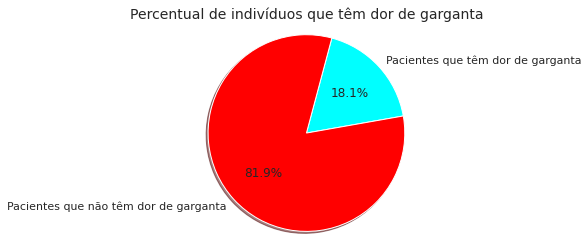

In [ ]:
labels='Pacientes que têm dor de garganta','Pacientes que não têm dor de garganta'
size =[g_t['F']+g_t['M'],g_f['M']+g_f['F']]
color_list = ['cyan','red']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que têm dor de garganta',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que têm dispneia
disp_t = Counter(df['CS_SEXO'].loc[df['DISPNEIA'] == 1.0])
disp_f = Counter(df['CS_SEXO'].loc[df['DISPNEIA'] == 2.0])
print('Pacientes que têm dispneia:', disp_t)
print('Pacientes que não têm dispneia:', disp_f)

Pacientes que têm dispneia: Counter({'M': 2818, 'F': 2653})
Pacientes que não têm dispneia: Counter({'M': 887, 'F': 883})


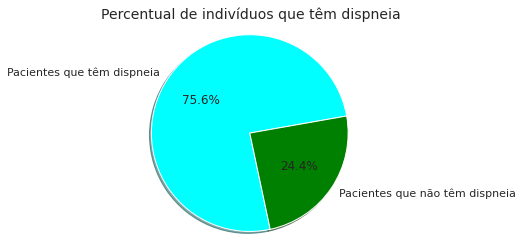

In [ ]:
labels='Pacientes que têm dispneia','Pacientes que não têm dispneia'
size =[disp_t['F']+disp_t['M'],disp_f['M']+disp_f['F']]
color_list = ['cyan','green']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que têm dispneia',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que tiveram dor abdominal
dorab_t = Counter(df['CS_SEXO'].loc[df['DOR_ABD'] == 1.0])
dorab_f = Counter(df['CS_SEXO'].loc[df['DOR_ABD'] == 2.0])
print('Pacientes que têm dor abdominal:', dorab_t)
print('Pacientes que não têm dor abdominal:', dorab_f)

Pacientes que têm dor abdominal: Counter({'F': 270, 'M': 249})
Pacientes que não têm dor abdominal: Counter({'M': 3456, 'F': 3266})


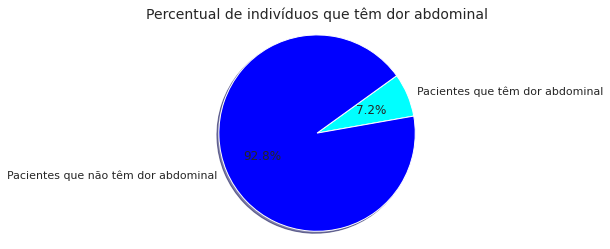

In [ ]:
labels='Pacientes que têm dor abdominal','Pacientes que não têm dor abdominal'
size =[dorab_t['F']+dorab_t['M'],dorab_f['M']+dorab_f['F']]
color_list = ['cyan','blue']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que têm dor abdominal',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

In [ ]:
#Verificando os pacientes que tiveram fadiga
fag_t = Counter(df['CS_SEXO'].loc[df['FADIGA'] == 1.0])
fag_f = Counter(df['CS_SEXO'].loc[df['FADIGA'] == 2.0])
print('Pacientes que têm fadiga:', fag_t)
print('Pacientes que não têm fadiga:', fag_f)

Pacientes que têm fadiga: Counter({'M': 1271, 'F': 1201})
Pacientes que não têm fadiga: Counter({'M': 2434, 'F': 2335})


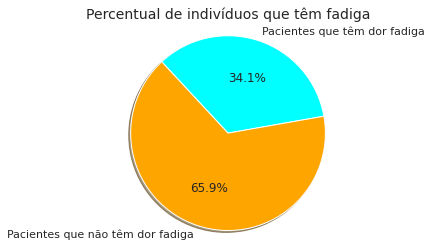

In [ ]:
labels='Pacientes que têm dor fadiga','Pacientes que não têm dor fadiga'
size =[fag_t['F']+fag_t['M'],fag_f['M']+fag_f['F']]
color_list = ['cyan','orange']
figl, axl = plt.subplots()
axl.pie(size,labels=labels,shadow = True,autopct='%1.1f%%', startangle = 10,colors=color_list)
axl.axis('equal')
axl.set_title('Percentual de indivíduos que têm fadiga',fontsize = 14)
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
plt.show()

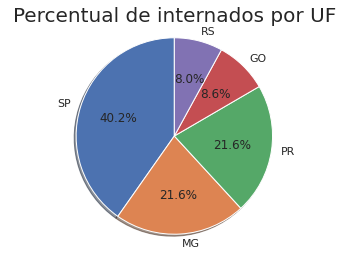

In [ ]:
#Verificando os pacientes de internados por UF
UFs = OrderedDict(Counter(df["SG_UF"]).most_common(5))
UFs
labels= UFs.keys()
size =UFs.values()
# color_list = ['red','green']
figl, axl = plt.subplots()
axl.pie(size, labels=labels, shadow = True, autopct='%1.1f%%', startangle = 90)
axl.axis('equal')
axl.set_title('Percentual de internados por UF',fontsize = 20)
sns.set(style="whitegrid")
sns.set_color_codes("bright")
plt.show()

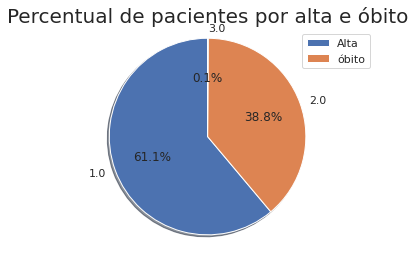

In [ ]:
#Verificando os pacientes de internados por alta e óbito
EVO = OrderedDict(Counter(df["EVOLUCAO"]).most_common(5))
EVO
labels= EVO.keys()
size = EVO.values()
figl, axl = plt.subplots()
axl.pie(size, labels=labels, shadow = True, autopct='%1.1f%%', startangle = 90)
axl.axis('equal')
axl.set_title('Percentual de pacientes por alta e óbito',fontsize = 20)
axl.legend(["Alta", "óbito"])
sns.set(style="whitegrid")
sns.set_color_codes("bright")
plt.show()

In [ ]:
#Tirando os óbitos por outras causas do Dataset
df = df[df['EVOLUCAO'].values != 3.0]
df

,SEM_NOT,SEM_PRI,CS_SEXO,CS_GESTANT,SG_UF,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,VACINA,HOSPITAL,SG_UF_INTE,CO_RG_INTE,CO_MU_INTE,UTI,RAIOX_RES,AMOSTRA,PCR_RESUL,POS_PCRFLU,POS_PCROUT,CLASSI_FIN,CRITERIO,EVOLUCAO,HISTO_VGM,PCR_SARS2,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,ESTRANG,VACINA_COV
117,3,2,F,0,SP,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,"CEFALEIA,CORIZA",2.0,1,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,SP,1354.0,354980.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0
263,4,2,F,0,SP,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,FRAQUEZA,2.0,1,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,SP,1335.0,353440.0,1.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
1017,7,6,M,0,BA,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,"ARTRALGIA, HIPOREXIA",2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,BA,1380.0,292740.0,1.0,5.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,5.0,2.0,1.0
1780,10,9,F,0,SC,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,"CEFALEIA, DOR NO CORPO, CORIZA",2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,SC,1565.0,420910.0,2.0,3.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,0,1.0,2.0,2.0,1.0,1.0,6.0,2.0,2.0
2210,11,9,F,0,SC,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,CANSACO,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,SC,1564.0,420240.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470106,26,25,F,0,RS,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,"MIALGIA, CONTATO FILHA +",2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,RS,1593.0,431440.0,1.0,5.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,0,1.0,2.0,2.0,2.0,2.0,6.0,2.0,2.0
1470510,26,24,F,0,PR,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,"MIALGIA, CEFALEIA,CIANOSE",2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,PR,1363.0,410830.0,2.0,5.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0
1470900,28,27,M,0,MS,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,CORIZA,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,MS,1975.0,500325.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0
1471026,33,32,F,0,GO,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,ASTENIA,2.0,1,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,GO,1792.0,520110.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0


In [ ]:
#Quantidade das nossas labels
from collections import Counter
Counter(df['EVOLUCAO'])

Counter({1.0: 4426, 2.0: 2808})

In [ ]:
#Dataframe com apenas colunas numéricas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = df.select_dtypes(include=numerics)

In [ ]:
newdf

,SEM_NOT,SEM_PRI,CS_GESTANT,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,VACINA,HOSPITAL,CO_RG_INTE,CO_MU_INTE,UTI,RAIOX_RES,AMOSTRA,PCR_RESUL,POS_PCRFLU,POS_PCROUT,CLASSI_FIN,CRITERIO,EVOLUCAO,HISTO_VGM,PCR_SARS2,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,ESTRANG,VACINA_COV
117,3,2,0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1354.0,354980.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0
263,4,2,0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1335.0,353440.0,1.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
1017,7,6,0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1380.0,292740.0,1.0,5.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,5.0,2.0,1.0
1780,10,9,0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1565.0,420910.0,2.0,3.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,0,1.0,2.0,2.0,1.0,1.0,6.0,2.0,2.0
2210,11,9,0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1564.0,420240.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470106,26,25,0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1593.0,431440.0,1.0,5.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,0,1.0,2.0,2.0,2.0,2.0,6.0,2.0,2.0
1470510,26,24,0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1363.0,410830.0,2.0,5.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0
1470900,28,27,0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1975.0,500325.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0
1471026,33,32,0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1792.0,520110.0,2.0,6.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0


In [ ]:
#Dividindo nossos dados em X e Y
X = newdf.drop(['EVOLUCAO'], axis = 1)
y = df['EVOLUCAO']

In [ ]:
#Dividindo entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, stratify=y)

In [ ]:
#Quantidade dos dados de treino e teste
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

5425 5425
1809 1809


In [ ]:
#Calculando o AIC
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

7637.228366006473




---

#Modelo de Classificação

---



In [ ]:
#Modelo de classificação
classifier = make_pipeline(MinMaxScaler(), SVC(gamma='auto')) 
classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
#Y predito
y_pred_clf = classifier.predict(X_test)
y_pred_clf

array([1., 2., 2., ..., 1., 2., 2.])

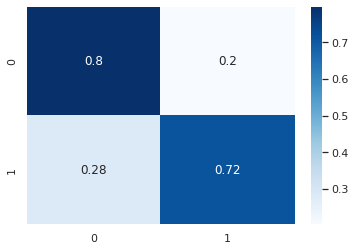

In [ ]:
# Matriz de Confusão da classificação do modelo
cm = confusion_matrix(y_test, y_pred_clf, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
#Métricas do modelo de classificação
print(classification_report(y_test, y_pred_clf, digits=4))

              precision    recall  f1-score   support

         1.0     0.8152    0.7967    0.8058      1107
         2.0     0.6905    0.7151    0.7026       702

    accuracy                         0.7651      1809
   macro avg     0.7528    0.7559    0.7542      1809
weighted avg     0.7668    0.7651    0.7658      1809





---

#Modelo de Regressão

---



In [ ]:
#Modelo de regressão
regression = make_pipeline(QuantileTransformer(output_distribution="uniform"), LogisticRegression(C=0.3, solver='liblinear', penalty='l1', max_iter=100))
regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('quantiletransformer',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('logisticregression',
                 LogisticRegression(C=0.3, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
#Y predito
y_pred_reg = regression.predict(X_test)
y_pred_reg

array([1., 2., 2., ..., 1., 2., 2.])

In [ ]:
#Função do MAPE
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
#Métricas do modelo de regressão
print('Mape:', MAPE(y_test, y_pred_reg))
print('R2: ',r2_score(y_test, y_pred_reg))
print('Max_error: ',max_error(y_test, y_pred_reg))
print('mean_absolute_error: ',mean_absolute_error(y_test, y_pred_reg))
print('mean_squared_error: ',mean_squared_error(y_test, y_pred_reg))
print('root_mean_squared_error: ',mean_squared_error(y_test, y_pred_reg, squared=False))

Mape: 17.24709784411277
R2:  0.017649920088944726
Max_error:  1.0
mean_absolute_error:  0.23327805417357655
mean_squared_error:  0.23327805417357655
root_mean_squared_error:  0.48298866878383034


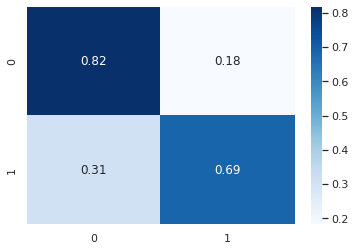

In [ ]:
# Matriz de Confusão da regressão do modelo
cm = confusion_matrix(y_test, y_pred_reg, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
#Métricas do modelo de classificação
print(classification_report(y_test, y_pred_reg, digits=4))

              precision    recall  f1-score   support

         1.0     0.8044    0.8175    0.8109      1107
         2.0     0.7047    0.6866    0.6955       702

    accuracy                         0.7667      1809
   macro avg     0.7546    0.7521    0.7532      1809
weighted avg     0.7657    0.7667    0.7661      1809



###Não supervisionado



---

#K-Means

---



In [ ]:
#Modelo K-Means
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
#Y predito do modelo K-Means
y_pred = kmeans.predict(X)
Counter(y_pred)

Counter({0: 4208, 1: 3026})

In [ ]:
#Silhouette Score do K-Means
silhouette_score(X, y_pred)

0.6447773821461549

In [ ]:
#Aplicando o MinMax no X
scaler = MinMaxScaler()
X_mm = scaler.fit_transform(X)

In [ ]:
#Modelo K-Means para o X com MinMax
kmeans_mm = KMeans(n_clusters=2)
kmeans_mm.fit(X_mm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
#Y predito do modelo K-Means com MinMax
y_pred_mm = kmeans.predict(scaler.inverse_transform(X_mm))
Counter(y_pred_mm)

Counter({0: 4208, 1: 3026})

In [ ]:
#Silhouette Score do K-Means com MinMax
silhouette_score(X, y_pred_mm)

0.6447773821461549



---

#Fuzzy C-Means

---



In [ ]:
#Modelo Fuzzy C-Means
fcm = FCM(n_clusters=2)
fcm.fit(np.array(X))

In [ ]:
#Y predito do modelo Fuzzy C-Means
y_pred_c = fcm.predict(np.array(X))
Counter(y_pred_c)

Counter({0: 4208, 1: 3026})

In [ ]:
#Silhouette Score do Fuzzy C-Means
silhouette_score(X, y_pred_c)

0.6447773821461549

In [ ]:
#Modelo Fuzzy C-Means com MinMax
fcm_mm = FCM(n_clusters=2)
fcm_mm.fit(np.array(X_mm))

In [ ]:
#Y predito do modelo Fuzzy C-Means com MinMax
y_pred_c_mm = fcm_mm.predict(scaler.inverse_transform(X_mm))
Counter(y_pred_c_mm)

Counter({0: 7234})

In [ ]:
#Silhouette Score do Fuzzy C-Means com MinMax
silhouette_score(X, y_pred_mm)

0.6447773821461549